In [2]:
import pandas as pd
import numpy as np
import random

import quantlib
import quantlib.indicators_cal as indicators_cal
import quantlib.diagnostics_utils as diagnostics_utils

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_instruments_from_df(df):
    instruments = []
    for col in df.columns:
        inst = col.split(" ")[0]
        if "USD" in inst and inst not in instruments:
            instruments.append(inst)
    return instruments

origin_df = pd.read_excel("../crypto_historical_4h.xlsx", engine="openpyxl", index_col='open_time')
origin_df.columns

Index(['BTCUSDT open', 'BTCUSDT high', 'BTCUSDT low', 'BTCUSDT close',
       'BTCUSDT quote_volume', 'BTCUSDT count',
       'BTCUSDT taker_buy_quote_volume', 'ETHUSDT open', 'ETHUSDT high',
       'ETHUSDT low',
       ...
       'AGIXUSDT avg trade size', 'AGIXUSDT taker %', 'AGIXUSDT % ret',
       'AGIXUSDT % ret vol', 'AGIXUSDT active', 'GMXUSDT avg trade size',
       'GMXUSDT taker %', 'GMXUSDT % ret', 'GMXUSDT % ret vol',
       'GMXUSDT active'],
      dtype='object', length=1992)

In [11]:
periods = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100]
look_ahead = periods[2]
IGNORES = 1 # We do not want to count the closest momentum for possible reversion

instruments = get_instruments_from_df(origin_df)
remove_instruments = []

df = origin_df.copy()
for inst in instruments:
    for p in periods:
        df["{} {} ret".format(inst, p)] = df["{} close".format(inst)].shift(IGNORES) / df["{} close".format(inst)].shift(p+IGNORES) - 1
        df["{} {} fwd ret".format(inst, p)] = df["{} close".format(inst)].shift(-p) / df["{} close".format(inst)] - 1

for inst in instruments:
    if df[f"{inst} {periods[0]} fwd ret"].iloc[0] == 0:
        remove_instruments.append(inst)

df_cols = [col for col in df.columns if col.split(" ")[0] not in remove_instruments]
df = df[df_cols]

In [12]:
target_instruments = [x for x in instruments if x not in remove_instruments]

def set_rank_df(periods, index, rank_df, target_df, instruments):
    for inst in instruments:
        for p in periods:
            rank_df.loc[index, f"{inst} {p} ret"] = target_df.loc[index, f"{inst} {p} ret"]
            rank_df.loc[index, f"{inst} {p} fwd ret"] = target_df.loc[index, f"{inst} {p} fwd ret"]
            rank_df.loc[index, f"{inst} % ret vol"] = target_df.loc[index, f"{inst} % ret vol"]
    return rank_df

def get_momentum_rank(df, rebalance_period=10):
    instruments = get_instruments_from_df(df)
    target_df = df.copy().reset_index()
    rank_df = pd.DataFrame()
    for i in target_df.index:
        if i % rebalance_period == 1 and i != 1:
            rank_df = set_rank_df(periods, i, rank_df, target_df, instruments)

    rank_df = rank_df.dropna(axis=0).reset_index(drop=True)
    return rank_df

rank_df = get_momentum_rank(df, look_ahead)

In [13]:
rank_df

,BTCUSDT 10 ret,BTCUSDT 10 fwd ret,BTCUSDT % ret vol,BTCUSDT 15 ret,BTCUSDT 15 fwd ret,BTCUSDT 20 ret,BTCUSDT 20 fwd ret,BTCUSDT 25 ret,BTCUSDT 25 fwd ret,BTCUSDT 30 ret,...,OPUSDT 60 ret,OPUSDT 60 fwd ret,OPUSDT 65 ret,OPUSDT 65 fwd ret,OPUSDT 70 ret,OPUSDT 70 fwd ret,OPUSDT 75 ret,OPUSDT 75 fwd ret,OPUSDT 100 ret,OPUSDT 100 fwd ret
0,0.062498,0.058915,0.014721,0.051364,0.049322,0.080900,0.048034,0.100325,0.052268,0.129135,...,0.213591,0.573569,0.238543,1.347795,0.318983,1.490509,0.329095,1.580848,0.352874,2.040103
1,-0.032165,-0.041681,0.023000,0.033601,-0.021584,0.017547,-0.057560,0.055150,-0.081619,0.081142,...,0.324526,1.125498,0.285157,1.112897,0.210075,0.928121,0.223775,1.084351,0.235137,1.501607
2,-0.008505,-0.043467,0.014352,-0.043651,-0.015628,-0.002788,0.057096,-0.045665,0.095160,-0.034863,...,0.867507,1.478706,0.968723,1.230277,0.973797,1.155923,0.954903,1.335234,0.569063,0.943449
3,0.105089,0.030066,0.016651,0.047414,0.022674,0.015343,0.031455,0.026444,0.009050,0.006708,...,0.540799,0.764466,0.904696,0.793397,1.204953,0.731362,1.223756,0.465808,1.096879,0.426447
4,-0.000290,-0.040314,0.015306,-0.005923,-0.035804,0.036973,-0.031431,0.121312,-0.051354,0.145947,...,1.563458,0.010405,1.442363,-0.035148,1.464425,-0.067937,1.389061,-0.019601,2.603739,-0.141500
5,-0.003235,-0.006975,0.010577,-0.017863,0.004657,-0.040511,-0.002495,-0.046561,0.030892,-0.040789,...,1.165397,-0.261666,1.166812,-0.325369,1.225453,-0.304901,1.300578,-0.320439,1.799662,-0.482114
6,0.000910,0.034435,0.011572,0.024997,0.004955,0.008706,0.026066,0.006437,0.056914,0.005443,...,0.783510,-0.270573,1.402288,-0.302956,1.546343,-0.394757,1.343210,-0.373272,1.823504,-0.347880
7,0.007528,0.001562,0.012178,0.029582,0.039778,0.042765,0.039278,0.036094,0.028265,0.043714,...,-0.011616,-0.339480,0.025029,-0.294815,-0.047288,-0.324392,0.076923,-0.304455,0.907291,-0.381092
8,0.020034,-0.023707,0.011833,-0.004819,-0.027205,0.018571,-0.033277,0.059905,-0.046908,0.026239,...,-0.225779,-0.193349,-0.081167,-0.220244,0.083626,-0.246757,-0.024750,-0.290628,0.406775,-0.303789
9,-0.018074,-0.041210,0.010231,-0.020582,-0.122689,-0.026804,-0.116084,-0.040837,-0.098137,-0.007307,...,-0.268264,-0.271581,-0.278022,-0.257558,-0.251087,-0.206821,-0.251793,-0.173984,-0.194034,-0.162568


In [32]:
look_back = periods[6]
k=20

portfolio_df = pd.DataFrame(index=rank_df.index)
target_ret_cols = [f"{inst} {look_back} ret" for inst in target_instruments]
target_fwd_ret_cols = [f"{inst} {look_ahead} fwd ret" for inst in target_instruments]
target_ret_vol_cols = [f"{inst} % ret vol" for inst in target_instruments]


for i in rank_df.index:
    rank = pd.qcut(rank_df.loc[i, target_ret_cols], k, labels=False)
    for col in target_ret_cols:
        portfolio_df.loc[i, col] = int(rank[col])
    for col in target_fwd_ret_cols:
        portfolio_df.loc[i, col] = rank_df.loc[i, col]


def lookup_ret(index, portfolio_df, rank_portfolio):
    fwd_ret_cols = []
    ret_cols = []
    ret_vol_cols = []
    for inst in rank_portfolio:
        for col in target_fwd_ret_cols:
            if inst in col: fwd_ret_cols.append(col)
        for col in target_ret_cols:
            if inst in col: ret_cols.append(col)
        for col in target_ret_vol_cols:
            if inst in col: ret_vol_cols.append(col)
    
    ret_vols = 1 / (rank_df.loc[index, ret_vol_cols] + 0.02)
    ret_vols_percent = ret_vols / ret_vols.sum()
    #inst_fwd_ret = rank_df.loc[index, fwd_ret_cols].mean()
    inst_fwd_ret = np.average(rank_df.loc[index, fwd_ret_cols], weights=ret_vols_percent)
    inst_ret = rank_df.loc[index, ret_cols].mean()
    inst_ret_vol = rank_df.loc[index, ret_vol_cols].mean()
    return inst_fwd_ret, inst_ret, inst_ret_vol
        

rank_cols = [i for i in range(k)]
result_df = pd.DataFrame(index=portfolio_df.index, columns=rank_cols)
for i in portfolio_df.index:
    result_df.loc[i, rank_cols] = [[] for _ in range(k)]
    for col in target_ret_cols:
        inst = col.split(" ")[0]
        rank = portfolio_df.loc[i, col]
        result_df.loc[i, rank].append(inst)

for i in result_df.index:
    for rank in result_df[rank_cols]:
        rank_portfolio = result_df.loc[i, rank]
        inst_fwd_ret, inst_ret, inst_ret_vol = lookup_ret(i, portfolio_df, rank_portfolio)
        result_df.loc[i, f"rank {rank} fwd ret"] = inst_fwd_ret
        result_df.loc[i, f"rank {rank} ret"] = inst_ret
        result_df.loc[i, f"rank {rank} ret vol"] = inst_ret_vol


fwd_ret = result_df[[f"rank {rank} fwd ret" for rank in range(k)]].mean().reset_index(drop=True)
ret = result_df[[f"rank {rank} ret" for rank in range(k)]].mean().reset_index(drop=True)
compare_df = pd.concat({f"{look_back} Return": ret, f"{look_ahead} Forward Return": fwd_ret},
                    axis=1)
compare_df = compare_df.apply(lambda x: x*100)

compare_df



,40 Return,20 Forward Return
0,-13.374480,-1.234740
1,-7.707592,0.067056
2,-5.939302,0.249176
3,-4.752978,0.116279
4,-3.849955,0.192837
5,-3.177697,0.190649
6,-2.602645,0.757738
7,-2.014169,0.162623
8,-1.295941,0.349722
9,-0.733623,0.245691


In [29]:
"""
k_list = np.arange(10, 21)
look_back_list = periods

max_sharpe, max_k, max_look_back = 0, 0, 0
for k in k_list:
    for look_back in look_back_list:
        sharpe = main(look_back, k)
        print (sharpe)
        if sharpe > max_sharpe:
            max_sharpe = sharpe
            max_k, max_look_back = k, look_back

print (max_sharpe, max_k, max_look_back)
"""

'\nk_list = np.arange(10, 21)\nlook_back_list = periods\n\nmax_sharpe, max_k, max_look_back = 0, 0, 0\nfor k in k_list:\n    for look_back in look_back_list:\n        sharpe = main(look_back, k)\n        print (sharpe)\n        if sharpe > max_sharpe:\n            max_sharpe = sharpe\n            max_k, max_look_back = k, look_back\n\nprint (max_sharpe, max_k, max_look_back)\n'

Sharpe ratio: 5.640025873404373
Max drawdown: -11.972593457189983%


<Axes: >

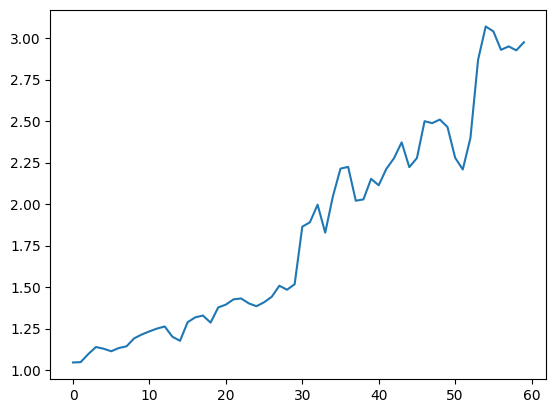

In [33]:
result_df["portfolio ret"] = result_df[f"rank {k-1} fwd ret"] - result_df["rank 0 fwd ret"]
sharpe = result_df["portfolio ret"].mean() / result_df["portfolio ret"].std() * np.sqrt(253)

result_df["portfolio ret"] = (1+result_df["portfolio ret"]).cumprod()
result_df["drawdown"] = result_df["portfolio ret"] / result_df["portfolio ret"].cummax() - 1
max_drawdown = result_df["drawdown"].min()*100
print (f"Sharpe ratio: {sharpe}")
print (f"Max drawdown: {max_drawdown}%")
result_df["portfolio ret"].plot()

In [31]:
# IGNORES = 5
# look back, look ahead = 50, 50
# k=12


"""
4h: lookback=40, lookahead=20, k=20, IGNORE=1
sharpe: 5.64
"""
result_df

,0,1,2,3,4,5,6,7,8,9,...,rank 17 ret,rank 17 ret vol,rank 18 fwd ret,rank 18 ret,rank 18 ret vol,rank 19 fwd ret,rank 19 ret,rank 19 ret vol,portfolio ret,drawdown
0,"[LITUSDT, UNFIUSDT, OGNUSDT, BTCDOMUSDT, ARPAU...","[XTZUSDT, ONTUSDT, BELUSDT, MASKUSDT, PEOPLEUS...","[DOGEUSDT, KAVAUSDT, BANDUSDT, STORJUSDT, CTKU...","[IOTAUSDT, BATUSDT, SXPUSDT, HNTUSDT, CVCUSDT,...","[ZILUSDT, ANKRUSDT, ALICEUSDT, MTLUSDT, BAKEUS...","[ADAUSDT, ATOMUSDT, ZRXUSDT, ICXUSDT, MANAUSDT...","[TRXUSDT, XLMUSDT, VETUSDT, THETAUSDT, OMGUSDT...","[LINKUSDT, IOSTUSDT, WAVESUSDT, ONEUSDT, IOTXU...","[BTCUSDT, EOSUSDT, SRMUSDT, FTMUSDT, ZENUSDT, ...","[ZECUSDT, COMPUSDT, TOMOUSDT, XEMUSDT, HBARUSD...",...,0.214697,0.025474,0.040143,0.276423,0.030224,0.032191,0.319154,0.031992,1.046719,0.000000
1,"[SRMUSDT, EGLDUSDT, RSRUSDT, BELUSDT, BTSUSDT,...","[RLCUSDT, SUSHIUSDT, CTKUSDT, OGNUSDT, ARUSDT,...","[TRXUSDT, STORJUSDT, UNIUSDT, STMXUSDT, RAYUSD...","[BATUSDT, COMPUSDT, AAVEUSDT, CHZUSDT, LITUSDT...","[IOSTUSDT, ALGOUSDT, FILUSDT, BAKEUSDT, MASKUS...","[XLMUSDT, KAVAUSDT, HNTUSDT, CVCUSDT, C98USDT,...","[XRPUSDT, EOSUSDT, ZECUSDT, XTZUSDT, THETAUSDT...","[ZILUSDT, OMGUSDT, DEFIUSDT, RENUSDT, OCEANUSD...","[ONTUSDT, KNCUSDT, ZRXUSDT, SNXUSDT, CELOUSDT,...","[DASHUSDT, BANDUSDT, MKRUSDT, YFIUSDT, GRTUSDT...",...,0.211005,0.032779,-0.096957,0.232836,0.040016,-0.066220,0.357393,0.039058,1.042483,-0.004047
2,"[SUSHIUSDT, SRMUSDT, EGLDUSDT, RSRUSDT, BTSUSD...","[ZECUSDT, RLCUSDT, LRCUSDT, RVNUSDT, NKNUSDT, ...","[RENUSDT, AAVEUSDT, GTCUSDT, AUDIOUSDT, MASKUS...","[BATUSDT, STORJUSDT, BELUSDT, GRTUSDT, ARPAUSD...","[TRXUSDT, IOSTUSDT, COMPUSDT, FILUSDT, CTKUSDT...","[UNFIUSDT, BTCDOMUSDT, C98USDT, ROSEUSDT, WOOU...","[ALGOUSDT, MKRUSDT, SOLUSDT, ICXUSDT, OCEANUSD...","[HNTUSDT, MATICUSDT, CVCUSDT, LINAUSDT, OGNUSD...","[XRPUSDT, DOTUSDT, 1INCHUSDT, CHRUSDT, STMXUSD...","[ZRXUSDT, KAVAUSDT, UNIUSDT, ATAUSDT, 1000XECU...",...,0.080227,0.027003,0.106571,0.114593,0.026478,0.103337,0.218833,0.036544,1.087858,0.000000
3,"[ATOMUSDT, FLMUSDT, ONEUSDT, MTLUSDT, IOTXUSDT...","[SOLUSDT, TOMOUSDT, RENUSDT, RSRUSDT, LRCUSDT,...","[SRMUSDT, AVAXUSDT, HNTUSDT, SANDUSDT, REEFUSD...","[ALGOUSDT, RLCUSDT, RUNEUSDT, COTIUSDT, C98USD...","[CRVUSDT, ALPHAUSDT, ZENUSDT, SKLUSDT, NKNUSDT...","[NEARUSDT, LINAUSDT, ARUSDT, ARPAUSDT, ANTUSDT...","[COMPUSDT, ENJUSDT, ANKRUSDT, BTCDOMUSDT, CELO...","[DOGEUSDT, EGLDUSDT, BELUSDT, BAKEUSDT, LPTUSD...","[XTZUSDT, STORJUSDT, BTSUSDT, HBARUSDT, HOTUSD...","[BATUSDT, ZILUSDT, SXPUSDT, ICXUSDT, AAVEUSDT,...",...,0.076399,0.025013,0.117635,0.142152,0.032015,0.139835,0.320259,0.038600,1.124775,0.000000
4,"[CRVUSDT, FTMUSDT, KSMUSDT, NEARUSDT, SANDUSDT...","[ALGOUSDT, RUNEUSDT, HNTUSDT, ONEUSDT, MTLUSDT...","[ADAUSDT, XMRUSDT, DOGEUSDT, SRMUSDT, AVAXUSDT...","[BTCUSDT, LTCUSDT, TRXUSDT, STORJUSDT, BLZUSDT...","[XLMUSDT, WAVESUSDT, TOMOUSDT, XEMUSDT, DENTUS...","[ETHUSDT, DASHUSDT, XTZUSDT, BATUSDT, COTIUSDT...","[ATOMUSDT, SOLUSDT, MATICUSDT, CVCUSDT, AXSUSD...","[XRPUSDT, THETAUSDT, SNXUSDT, EGLDUSDT, ENJUSD...","[IOTAUSDT, KAVAUSDT, LRCUSDT, REEFUSDT, SFPUSD...","[LINKUSDT, NEOUSDT, ZILUSDT, COMPUSDT, ZENUSDT...",...,0.247634,0.035693,-0.007253,0.313245,0.049796,-0.025779,0.618021,0.062270,1.105394,-0.017231
5,"[BCHUSDT, EOSUSDT, LTCUSDT, QTUMUSDT, HNTUSDT,...","[RUNEUSDT, SRMUSDT, SOLUSDT, SANDUSDT, BTCDOMU...","[BTCUSDT, TRXUSDT, XMRUSDT, DOGEUSDT, BALUSDT,...","[ETHUSDT, ADAUSDT, ATOMUSDT, ALGOUSDT, KNCUSDT...","[DASHUSDT, ZECUSDT, BATUSDT, NEOUSDT, AVAXUSDT...","[OMGUSDT, LRCUSDT, MATICUSDT, CHRUSDT, AUDIOUS...","[XLMUSDT, WAVESUSDT, STORJUSDT, OCEANUSDT, OGN...","[MKRUSDT, XEMUSDT, MANAUSDT, HBARUSDT, MTLUSDT...","[COMPUSDT, CRVUSDT, SUSHIUSDT, FTMUSDT, AAVEUS...","[XRPUSDT, ZILUSDT, DOTUSDT, EGLDUSDT, AXSUSDT,...",...,0.188519,0.030840,0.002789,0.257174,0.032874,0.010361,0.476476,0.042142,1.093941,-0.027414
6,"[EOSUSDT, SOLUSDT, FILUSDT, ALICEUSDT, STMXUSD...","[ZRXUSDT, HNTUSDT, GRTUSDT, RAYUSDT, KLAYUSDT,...","[BCHUSDT, XRPUSDT, ETCUSDT